In [2]:
#%reset
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as sk
import keras
from sklearn import metrics
from keras import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, matthews_corrcoef,
                             roc_auc_score, make_scorer)
from sklearn.model_selection import (cross_validate, RandomizedSearchCV,
                                     RepeatedStratifiedKFold)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from eli5.sklearn import PermutationImportance
from matplotlib.patches import Polygon
from scipy.stats import loguniform
from tensorflow import random
from keras.metrics import AUC
from sklearn.feature_selection import SelectFromModel
#from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}
import pickle
## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP',
       'Susceptible', 'REGION', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION',
       'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75',
       'Trend_N_greater_75'],
      dtype='object')


In [3]:


################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]

### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# logistic regression 
best_hyperparameters_by_year = {}

space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}

# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_nn,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models_sd = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))


oversample = RandomOverSampler(sampling_strategy='minority', random_state=10)

def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):

    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[
        feature_names
    ]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)
    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev)

def get_best_features(feature_names, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    important_features = []

    for q in PI.importances_mean.argsort()[::-1]:
        if (PI.importances_mean[q] - PI.importances_std[q] >=0) & (PI.importances_mean[q] >0):
            print(PI.importances_mean[q])
            print(feature_names[q])
            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    feature_importances_dict = {feature_names[i]: PI.importances_mean[i] for i in range(len(feature_names))}
    feature_importances = [feature_importances_dict[feature] for feature in feature_names]

    return important_features, feature_importances

def get_feature_effects_sd(feature_names, important_features,model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )

    return PI.importances_std

def get_best_hyperparameters(model, cv, space, X_train, y_train, sample_weights):
    search = RandomizedSearchCV(
        model, space, scoring="roc_auc", n_iter=20, n_jobs=-1, cv=cv, random_state=1
    )
    result = search.fit(X_train, y_train, sample_weight = sample_weights)
    return result.best_params_

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):
    feature_names_with_weight = feature_names.copy()
    feature_names_with_weight.extend(['weight'])
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[feature_names_with_weight]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names_with_weight]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)

    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    weights_train = X_train["weight"]
    X_train  = X_train.drop("weight", axis = 1)
    X_test = X_test.drop("weight", axis = 1)

    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train)

In [54]:
# Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)
i = 0
test_years = np.array(range(2005, 2011))

for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    best_hyperparameters1 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train, weights_train)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'])
    
    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_fit = model_lr.fit(X_train, y_train, sample_weight = weights_train)

    ## now also need to do feature engineering
    important_features, imporances_all_models[i + indices_for_importance[model_type]] = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    #imporances_all_models[i + indices_for_importance[model_type]],  = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model
    #imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train, weights_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 


    ## fit model w/hyperparameters 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_lr_" + str(year) + ".sav" 

    pickle.dump(model_lr, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    print(ROC)
    i += 1

2005


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1
0.004121586810922262
West
0.0030293663060278696
Northeast
0.002524471921689908
MSW
0.0017070238708569718
Southwest
0.0012811265670616856
MSM
0.00010647432594885764
MSMW


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7304247515090889
2006


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1
0.01688720645874513
West
0.005480553415295996
Southwest
0.004535861445177725
Southeast
0.004308063381461269
MSW
0.0011423402901075685
MSM
0.00037184683930191476
Oth/Unk/Missing


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.722997895527232
2007


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1
0.01614099576618864
MSW
0.00851357117069813
West
0.003085102891463509
Oth/Unk/Missing
0.0022908529981293113
PREV_CLINIC
0.0021169057074404197
Southwest
0.001073221963307025
Trend_N_greater_75
0.0005251238964193661
Northeast
7.548656011030497e-05
Count_Exceeds_75


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7066233521880259
2008


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1
0.015268009120981519
West
0.010370299001188344
PREV_CLINIC
0.0026849086296047097
MSW
0.0013392427016090558
Count_Exceeds_75
0.0010534091274047475
Southwest
0.0006037832803417853
Oth/Unk/Missing


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7078638485409549
2009


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1
0.03000131873928529
PREV_CLINIC
0.022072398786759907
West
0.009610312541210652
MSW
0.007724515363312745
DELTA_CLINIC
0.0019945931689305365
MSM
0.0017638137940129694
Oth/Unk/Missing
0.0007088223658183179
Count_Exceeds_75


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6664640534593402
2010


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1
0.0447353328160318
PREV_CLINIC
0.028183934415168133
DELTA_CLINIC
0.020414291015822605
West
0.007462636213353069
MSW
0.007266961303599684
PREV_REGION
0.004611855200566717
Southeast
0.003859518909618398
MSM
0.0029958503424310614
Oth/Unk/Missing
0.0027529435579096264
DELTA_REGION
0.0026314901656488755
Northeast
0.0009109004419553535
Count_Exceeds_75


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6856022113843243


In [ ]:
## Just RF
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

space = dict()
space['n_estimators'] = np.arange(1, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 100, 1)
space['min_samples_leaf'] = np.arange(1, 100, 1)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
test_years = [2007]  #np.array(range(2005, 2011))

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train, weights_train)
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 10)
    
     
    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train, sample_weight = weights_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train, weights_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)

    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_rf_" + str(year) + ".sav" 
    pickle.dump(model_rf, open(model_name, 'wb'))
    ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

In [ ]:
CIP_data_training_years = CIP_data_training_years.drop('weight_x', axis = 1)
CIP_data_training_years = CIP_data_training_years.drop('weight_y', axis = 1)

In [5]:
ROC_by_year_only_LR_RF = [{2005: 0.7304247515090889, 2006: 0.722997895527232, 2007: 0.7066233521880259, 2008: 0.7078638485409549, 2009: 0.6664640534593402, 2010: 0.6856022113843243}, {2005: 0.7549897391764862, 2006: 0.7595409738925509, 2007: 0.7015889650707939, 2008: 0.6966628419433072, 2009: 0.680609279672774, 2010: 0.6846061254892631}, {}]
best_hyperparameters_by_year_only_LR_RF =  [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2009: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}},{}]
best_features_by_year_only_LR_RF =  [{2005: ['West', 'Northeast', 'MSW', 'Southwest', 'MSM', 'MSMW'], 2006: ['West', 'Southwest', 'Southeast', 'MSW', 'MSM', 'Oth/Unk/Missing'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'PREV_CLINIC', 'Southwest', 'Trend_N_greater_75', 'Northeast', 'Count_Exceeds_75'], 2008: ['West', 'PREV_CLINIC', 'MSW', 'Count_Exceeds_75', 'Southwest', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'West', 'MSW', 'DELTA_CLINIC', 'MSM', 'Oth/Unk/Missing', 'Count_Exceeds_75'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'PREV_REGION', 'MSM', 'Southeast', 'Oth/Unk/Missing', 'DELTA_REGION', 'Northeast', 'Count_Exceeds_75']}, {2005: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Count_Exceeds_75', 'Southeast', 'Trend_N_greater_75', 'Southwest', 'Oth/Unk/Missing'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Midwest', 'Oth/Unk/Missing', 'Southeast', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Midwest', 'Northeast', 'Southeast', 'Southwest'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'Count_Exceeds_75', 'Midwest', 'West', 'Trend_N_greater_75', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'Southwest', 'West', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southeast', 'Northeast', 'Trend_N_greater_75'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Midwest', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Southeast', 'Trend_N_greater_75']}, {}]


# tensorflow

# SciKt Learn MLP classifier doesn't allow for sample weights, so need to use keras

In [13]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)

In [40]:


def get_best_features_and_effects_tensorflow(feature_names, model_nn, X_train, y_train, scorer, cv):
    model_nn_wrapped = KerasClassifier(model=lambda: model_nn, epochs=1, batch_size=1, verbose=0)
    model_nn_wrapped.fit(X_train, y_train, epochs=10, batch_size=best_hyperparameters_by_year[model_type][year]['kc__batch_size'], sample_weight=weights_train, verbose=0)

    # Calculate permutation importances
    perm = PermutationImportance(model_nn_wrapped, scoring=scorer, cv=cv, n_iter = 100, random_state=42)
    perm.fit(X_train, y_train)
    result = [(x[0], x[1], x[2]) for x in zip(perm.feature_importances_, perm.feature_importances_std_, X_train.columns)]

    important_features = [(name) for mean, std, name in result if mean - std >= 0]
    feature_effects = [(mean) for mean in result]

    return important_features, feature_effects


def get_feature_effects_sd_tensor_flow(feature_names, important_features, model_fit, X_train, y_train, n_repeats=10):
    def calculate_score(X, y):
        y_pred = model_fit.predict(X)
        return roc_auc_score(y, y_pred)  # Replace 'roc_auc_score' with your desired metric

    baseline_score = calculate_score(X_train, y_train)
    feature_effects_sd = {}

    for feature in important_features:
        X_permuted = X_train.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])

        permuted_scores = [calculate_score(X_permuted, y_train) for _ in range(n_repeats)]
        effect_sd = np.std(permuted_scores)

        feature_effects_sd[feature] = effect_sd

    return feature_effects_sd


def get_best_hyperparameters_tensorflow(estimator, param_space, cv, X_train, y_train, sample_weights):
    grid = RandomizedSearchCV(estimator, param_space, scoring="roc_auc", n_iter=10, n_jobs=-1, cv=cv, random_state=1)
    grid_result = grid.fit(X_train, y_train, kc__sample_weight=sample_weights)
    params = grid_result.best_params_
    return params
random.set_seed(10)
np.random.seed(10)

In [ ]:

def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(len(feature_names),), kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
    return model

kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros', dropout=0.1, dense_nparams=8, random_state=10)

estimator = Pipeline([
    ('ss', StandardScaler()),  # Use StandardScaler for numerical features
    ("kc", kears_estimator)
])

# Define the grid search parameters
param_grid = {
    'kc__dense_nparams': [2, 4, 6, 8, 10, 12, 14, 16],
    'kc__batch_size': [5, 10, 15, 20],
    'kc__optimizer': ['Adamax'],
    'kc__dropout': [0.075, 0.03, 0.05, 0.04, 0.025, 0]
}

scorer = make_scorer(roc_auc_score)
test_years = [2006]
i = 1
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year));

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)];
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])];
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count');
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count');

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'));

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum();

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts;
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left');

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type);
    best_hyperparameters1 = get_best_hyperparameters_tensorflow(estimator = estimator, param_space = param_grid, cv = cv, X_train = X_train, y_train = y_train, sample_weights = weights_train);
    model_nn = create_model(optimizer=best_hyperparameters1['kc__optimizer'], init='uniform', dropout=best_hyperparameters1['kc__dropout'], dense_nparams=best_hyperparameters1['kc__dense_nparams']);

    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_nn.fit(X_train, y_train, epochs=10, batch_size=best_hyperparameters1['kc__batch_size'], sample_weight=weights_train, verbose = 0);
    #model_fit = model_nn.copy()
    ## now also need to do feature engineering
    important_features, imporances_all_models[i + indices_for_importance[model_type]] =get_best_features_and_effects_tensorflow(feature_names, model_nn, X_train, y_train, scorer, cv)
    best_features_by_year[model_type].__setitem__(year, important_features);

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type);
    def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
        model = Sequential()
        model.add(Dense(dense_nparams, activation='relu', input_shape=(len(important_features),), kernel_initializer=init))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
        return model
    kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)
    estimator = Pipeline([
       ('ss', StandardScaler()),
        ("kc", kears_estimator)
    ])
    best_hyperparameters2 = get_best_hyperparameters_tensorflow(estimator = estimator, param_space = param_grid, cv = cv, X_train = X_train, y_train = y_train, sample_weights = weights_train);
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) ;
    model_nn = create_model(optimizer=best_hyperparameters2['kc__optimizer'], init='uniform', dropout=best_hyperparameters2['kc__dropout'], dense_nparams=best_hyperparameters2['kc__dense_nparams']);

    print("Hyperparameters2")
    ## fit model w/hyperparameters 
    model_nn.fit(X_train, y_train, epochs=100, batch_size=best_hyperparameters2['kc__batch_size'], sample_weight=weights_train, verbose = 0);

    # Make predictions on test data
    y_predict_proba = model_nn.predict(X_test);

    # Calculate AUROC on test data
    auc_metric = keras.metrics.AUC(num_thresholds=100);
    auc_metric.update_state(y_test, y_predict_proba);
    auroc = auc_metric.result().numpy();
 
    ROC_by_year[model_type].__setitem__(year, auroc);
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1);
    print(auroc)
    i += 1;

# DATA TO USE - ALL FEATURES, WEIGHTS, CORRECT No. ITERATIONS
[{2005: 0.7304247515090889, 2006: 0.722997895527232, 2007: 0.7066233521880259, 2008: 0.7078638485409549, 2009: 0.6664640534593402, 2010: 0.6856022113843243}, {2005: 0.7549897391764862, 2006: 0.7595409738925509, 2007: 0.7015889650707939, 2008: 0.6966628419433072, 2009: 0.680609279672774, 2010: 0.6846061254892631}, {2005: 0.79921305, 2006: 0.84113616, 2007: 0.7738805, 2008: 0.7741755, 2009: 0.7461454, 2010: 0.7617777}]
[{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2009: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}, {2005: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2006: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2007: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2008: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}, 2009: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2010: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}}]
[{2005: ['West', 'Northeast', 'MSW', 'Southwest', 'MSM', 'MSMW'], 2006: ['West', 'Southwest', 'Southeast', 'MSW', 'MSM', 'Oth/Unk/Missing'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'PREV_CLINIC', 'Southwest', 'Trend_N_greater_75', 'Northeast', 'Count_Exceeds_75'], 2008: ['West', 'PREV_CLINIC', 'MSW', 'Count_Exceeds_75', 'Southwest', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'West', 'MSW', 'DELTA_CLINIC', 'MSM', 'Oth/Unk/Missing', 'Count_Exceeds_75'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'PREV_REGION', 'Southeast', 'MSM', 'Oth/Unk/Missing', 'DELTA_REGION', 'Northeast', 'Count_Exceeds_75']}, {2005: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Count_Exceeds_75', 'Southeast', 'Trend_N_greater_75', 'Southwest', 'Oth/Unk/Missing'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Midwest', 'Oth/Unk/Missing', 'Southeast', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Midwest', 'Northeast', 'Southeast', 'Southwest'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'Count_Exceeds_75', 'Midwest', 'West', 'Trend_N_greater_75', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'Southwest', 'West', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southeast', 'Northeast', 'Trend_N_greater_75'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Midwest', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Southeast', 'Trend_N_greater_75']}, {2005: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2006: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2007: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2008: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2009: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2010: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']}]

In [56]:
print(ROC_by_year)
print(best_hyperparameters_by_year)
print(best_features_by_year)

[{2005: 0.7304247515090889, 2006: 0.722997895527232, 2007: 0.7066233521880259, 2008: 0.7078638485409549, 2009: 0.6664640534593402, 2010: 0.6856022113843243}, {2005: 0.7549897391764862, 2006: 0.7595409738925509, 2007: 0.7015889650707939, 2008: 0.6966628419433072, 2009: 0.680609279672774, 2010: 0.6846061254892631}, {2005: 0.79921305, 2006: 0.84113616, 2007: 0.7738805, 2008: 0.7741755, 2009: 0.7461454, 2010: 0.7617777}]
[{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2009: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_est

In [9]:
ROC_by_year = [{2005: 0.7304247515090889, 2006: 0.722997895527232, 2007: 0.7066233521880259, 2008: 0.7078638485409549, 2009: 0.6664640534593402, 2010: 0.6856022113843243}, {2005: 0.7549897391764862, 2006: 0.7595409738925509, 2007: 0.7015889650707939, 2008: 0.6966628419433072, 2009: 0.680609279672774, 2010: 0.6846061254892631}, {2005: 0.79921305, 2006: 0.84113616, 2007: 0.7738805, 2008: 0.7741755, 2009: 0.7461454, 2010: 0.7617777}]
best_hyperparameters_by_year = [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2009: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}, {2005: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2006: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2007: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2008: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}, 2009: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2010: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}}]
best_features_by_year = [{2005: ['West', 'Northeast', 'MSW', 'Southwest', 'MSM', 'MSMW'], 2006: ['West', 'Southwest', 'Southeast', 'MSW', 'MSM', 'Oth/Unk/Missing'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'PREV_CLINIC', 'Southwest', 'Trend_N_greater_75', 'Northeast', 'Count_Exceeds_75'], 2008: ['West', 'PREV_CLINIC', 'MSW', 'Count_Exceeds_75', 'Southwest', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'West', 'MSW', 'DELTA_CLINIC', 'MSM', 'Oth/Unk/Missing', 'Count_Exceeds_75'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'PREV_REGION', 'Southeast', 'MSM', 'Oth/Unk/Missing', 'DELTA_REGION', 'Northeast', 'Count_Exceeds_75']}, {2005: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Count_Exceeds_75', 'Southeast', 'Trend_N_greater_75', 'Southwest', 'Oth/Unk/Missing'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Midwest', 'Oth/Unk/Missing', 'Southeast', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Midwest', 'Northeast', 'Southeast', 'Southwest'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'Count_Exceeds_75', 'Midwest', 'West', 'Trend_N_greater_75', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'Southwest', 'West', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southeast', 'Northeast', 'Trend_N_greater_75'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Midwest', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Southeast', 'Trend_N_greater_75']}, {2005: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2006: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2007: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2008: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2009: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2010: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']}]

Get model weights (if lost)

In [59]:
#imporances_all_models.to_csv('imporances_all_models_with_weights_and_count_features.csv')

In [41]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)


In [42]:
## NN get effects
import tensorflow as tf
import logging
import os
scorer = make_scorer(roc_auc_score)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(len(feature_names),), kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
    return model

kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)

estimator = Pipeline([
    ('ss', StandardScaler()),  # Use StandardScaler for numerical features
    ("kc", kears_estimator)
])

test_years = [2010]
i = 5
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year));

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)];
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])];
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count');
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count');

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'));

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum();

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts;
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left');

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type);
    
    def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
        model = Sequential()
        model.add(Dense(dense_nparams, activation='relu', input_shape=(len(best_features_by_year[model_type][year]),), kernel_initializer=init))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
        return model
    kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)
    estimator = Pipeline([
       ('ss', StandardScaler()),
        ("kc", kears_estimator)
    ])

    model_nn = create_model(optimizer=best_hyperparameters_by_year[model_type][year]['kc__optimizer'], init='uniform', dropout=best_hyperparameters_by_year[model_type][year]['kc__dropout'], dense_nparams=best_hyperparameters_by_year[model_type][year]['kc__dense_nparams']);
    #model_name = "CIP_nn_" + str(year) 

    #model_fit_train = keras.models.load_model(model_name)

    important_features, imporances_all_models[i + indices_for_importance[model_type]] =get_best_features_and_effects_tensorflow(feature_names, model_nn, X_train, y_train, scorer, cv)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)




2010
Oversample


In [18]:
imporances_all_models.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)

In [25]:
#imporances_all_models.to_csv('imporances_all_models_with_weights_and_count_features.csv')

In [ ]:
## LR boostrapping
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)

    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = sample_weights)
    imporances_all_models[i + indices_for_importance[model_type]] = get_best_features(feature_names, model_fit, X_train, y_train)[1]

    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

In [46]:
## RF bootstrapping 
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years
    model_type = 1 
    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
 
    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = sample_weights)
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, best_features_by_year[model_type][year], model_fit_train, X_train, y_train) #want it to be the correct block for each model
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    i += 1

2005
Oversample
2006
Oversample
2007
Oversample
2008
Oversample
2009
Oversample
2010
Oversample


# auROC, features, and hyperparameters with weights caclulated by training set and extra features 


In [32]:
imporances_all_models= pd.read_csv('imporances_all_models_with_weights_and_count_features.csv')
imporances_all_models.drop(['Unnamed: 0'], axis = 1, inplace = True)

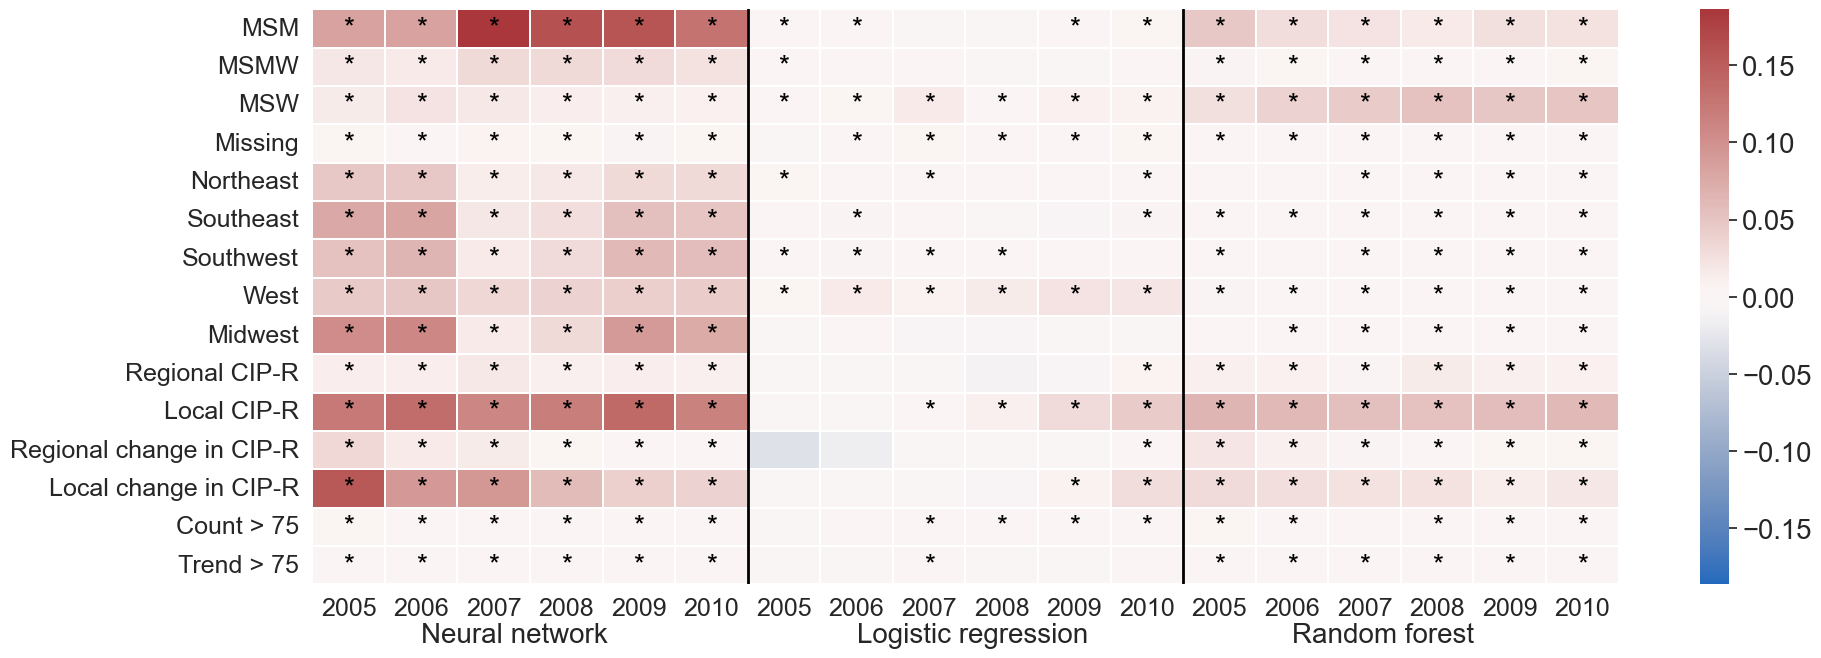

In [34]:
### Graph 2 of important features 
## Figure 1: Graph of important features

fig, ax = plt.subplots(figsize=(20,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]*3
y_axis_labels = ['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R', 'Count > 75', 'Trend > 75']

ax.tick_params(axis='both', which='major', labelsize=18)
included_features = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

model_types = [0, 1, 2]
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

for model in model_types:
    if model == 0:
             j = 6
    elif model == 1:
             j = 12
    elif model == 2:
             j =0
    for year in test_years:
        matched_indices = np.where(np.isin(feature_names, list(set(best_features_by_year[model][year]))))[0]

        for i in matched_indices:
                ax.text(j + 0.5, i + 0.5, '*', color='black', size=20, ha='center', va='center')
        j +=1
sb.heatmap(imporances_all_models,fmt="",cmap='vlag',linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =-abs(imporances_all_models.max()).max(), vmax = abs(imporances_all_models.max()).max())
ax.text((ax.get_xlim()[1])/18 * 1.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Neural network", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 7.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Logistic regression", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 13.5 , (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Random forest", fontsize=20)
ax.axvline((ax.get_xlim()[1])/18 * 6, color = "black", linewidth = 2)
ax.axvline((ax.get_xlim()[1])/18 * 12, color = "black", linewidth = 2)
plt.tight_layout()

#plt.show()

#plt.savefig('Graphs_all_fatures_weights/Magnitude_of_feature_importance_2005_2010_all_models.png', dpi = 300)

# Functions for bootstrapping

In [25]:
def calculate_percentiles(iterations, ROC_actual, test_data, model_type,y_test):
        bootstrapped_stats = []
        for j in range(iterations):
            model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
            X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            ## don't need to read in weights as the model has already been trained
            X_train_bootstrap = pd.read_csv(X_data_name)
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            if model_type == 2:
                model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) 

                model_fit = keras.models.load_model(model_name)
            else:
                model_fit = pickle.load(open(model_name, 'rb'))

            y_bootstrap_predict = model_fit.predict(X_test_for_bootstrap)

            ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

            difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

            bootstrapped_stats.append({'Difference': difference})


        bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization
        alpha = 0.05
        #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
        #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
        upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
        #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
        #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
 ## Step 4: Get optimization-corrected performance

        return lower_quartile, upper_quartile

### now try bootstrapping w/o feature selection
iterations = 100
## DO NOT SAMPLE THE TARGET DATA
def bootstrap_auROC_no_dev(iterations, model, train_data, test_data, y_test, ROC_actual, important_features):
      #1. Find apparent model performance
    bootstrapped_stats = []
    feature_names_with_weight = important_features.copy()
    feature_names_with_weight.extend(['weight'])
    for i in range(iterations):
        #2. (A) Sample all individuals from training data w/replacement

          sample_train = train_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
          
          X_sample_train = sample_train[feature_names_with_weight]
          y_sample_train = 1 - sample_train['Susceptible']

          if model_type in [1,2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)
          weights_train = X_sample_train["weight"]
          X_sample_train  = X_sample_train.drop("weight", axis = 1)
        #  (B) Predictive model w/o feature selection 
          X_test_bootstrap = test_data[important_features]
          model_fit = model.fit(X_sample_train, y_sample_train, sample_weight = weights_train)

          model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".sav" 
          X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          y_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_y_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          weights_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_weights_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          
          weights_train.to_csv(weights_data_name)
          X_sample_train.to_csv(X_data_name)
          y_sample_train.to_csv(y_data_name)
          pickle.dump(model_fit, open(model_name, 'wb'))
        #  (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
          y_bootstrap_predict = model_fit.predict(X_test_bootstrap)
          ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

          difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

          bootstrapped_stats.append(
          {

              'Difference': difference#,
          }
        )


    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization

    #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
    #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
 ## Step 4: Get optimization-corrected performance
    alpha = 0.05 
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile


def bootstrap_auROC_no_dev_tensorflow(iterations, model, train_data, test_data, y_test, ROC_actual, important_features, model_type):
    # 1. Find apparent model performance
    bootstrapped_stats = []
    feature_names_with_weight = important_features.copy()
    feature_names_with_weight.extend(['weight'])
    
    #for i in range(iterations):
    for i in iterations:
        # 2. (A) Sample all individuals from training data w/replacement
        sample_train = train_data.sample(frac = 1, replace=True)

        X_sample_train = sample_train[feature_names_with_weight]
        y_sample_train = 1 - sample_train['Susceptible']

        if model_type in [1, 2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train, y_sample_train)

        weights_train = X_sample_train["weight"]
        X_sample_train = X_sample_train.drop("weight", axis=1)

        # (B) Predictive model w/o feature selection
        X_test_bootstrap = test_data[important_features]
        def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
          model = Sequential()
          model.add(Dense(dense_nparams, activation='relu', input_shape=(len(best_features_by_year[model_type][year]),), kernel_initializer=init))
          model.add(Dropout(dropout))
          model.add(Dense(1, activation='sigmoid'))
          model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
          return model
        kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)
        estimator = Pipeline([
            ('ss', StandardScaler()),
              ("kc", kears_estimator)
          ])

        model = create_model(optimizer=best_hyperparameters_by_year[model_type][year]['kc__optimizer'], init='uniform', dropout=best_hyperparameters_by_year[model_type][year]['kc__dropout'], dense_nparams=best_hyperparameters_by_year[model_type][year]['kc__dense_nparams']);


        model.fit(X_sample_train, y_sample_train, epochs=100, batch_size=best_hyperparameters_by_year[model_type][year]['kc__batch_size'], sample_weight=weights_train, verbose=0);

        model_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_{model_type}_{year}_{i}"
        X_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_{model_type}_{year}_{i}.csv"
        y_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_y_no_dev_{model_type}_{year}_{i}.csv"
        weights_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_weights_{model_type}_{year}_{i}.csv"

        weights_train.to_csv(weights_data_name)
        X_sample_train.to_csv(X_data_name)
        y_sample_train.to_csv(y_data_name)
        keras.models.save_model(model,model_name)
        # (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
        y_bootstrap_predict = model.predict(X_test_bootstrap)
        ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict)

        # (D) Calculate estimate of variance by getting (B) - (C)
        difference = ROC_AUC_bootstrap_test_performance - ROC_actual

        bootstrapped_stats.append({
            'Difference': difference
        })

    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

    # Step 3: Get average optimization
    lower_quartile, upper_quartile = np.percentile(bootstrapped_stats["Difference"], [2.5, 97.5])

    # Step 4: Get optimization-corrected performance
    alpha = 0.05
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile

In [10]:
### quartile differece by year 
lower_quartile_by_year_rf = {}
lower_quartile_by_year_lr = {}
lower_quartile_by_year_nn = {}

lower_quartile_by_year = [lower_quartile_by_year_lr, lower_quartile_by_year_rf, lower_quartile_by_year_nn]

upper_quartile_by_year_rf = {}
upper_quartile_by_year_lr = {}
upper_quartile_by_year_nn = {}

upper_quartile_by_year = [upper_quartile_by_year_lr, upper_quartile_by_year_rf, upper_quartile_by_year_nn]


In [183]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)

In [54]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

In [204]:
## RF bootstrapping 
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years
    model_type = 1 
    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
   
    model_name = "CIP_rf_" + str(year) + ".sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = sample_weights)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_rf_" + str(year) + ".sav" 
    pickle.dump(model_rf, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_test)

    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)

2005
Oversample
2006
Oversample
2007
Oversample
2008
Oversample
2009
Oversample
2010
Oversample


In [207]:
## LR boostrapping
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
    model_name = "CIP_lr_" + str(year) + ".sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = sample_weights)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    pickle.dump(model_lr, open(model_name, 'wb'))
    #ROC= metrics.roc_auc_score(y_test, y_predict_test)
    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_lr, train_data, test_data, y_test, ROC_actual = ROC_by_year_lr[year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_lr, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)
    

2005
2006
2007
2008
2009
2010


In [27]:
## NN bootstrapping
import tensorflow as tf
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(len(feature_names),), kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
    return model

kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)

estimator = Pipeline([
    ('ss', StandardScaler()),  # Use StandardScaler for numerical features
    ("kc", kears_estimator)
])

# define the grid search parameters
param_grid = {
    'kc__dense_nparams': [2,4, 6, 8, 10, 12, 14, 16],
    'kc__batch_size': [5, 10, 15, 20],
    'kc__optimizer': [ 'Adamax'],
    'kc__dropout': [0.075, 0.03, 0.05, 0.04, 0.025, 0]
}
test_years = [2007]
iterations = range(37, 100)
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year));

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)];
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])];
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count');
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count');

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'));

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum();

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts;
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left');

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type);
    
    def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
        model = Sequential()
        model.add(Dense(dense_nparams, activation='relu', input_shape=(len(best_features_by_year[model_type][year]),), kernel_initializer=init))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
        return model
    kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)
    estimator = Pipeline([
       ('ss', StandardScaler()),
        ("kc", kears_estimator)
    ])

    model_nn = create_model(optimizer=best_hyperparameters_by_year[model_type][year]['kc__optimizer'], init='uniform', dropout=best_hyperparameters_by_year[model_type][year]['kc__dropout'], dense_nparams=best_hyperparameters_by_year[model_type][year]['kc__dense_nparams']);

    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_nn.fit(X_train, y_train, epochs=100, batch_size=best_hyperparameters_by_year[model_type][year]['kc__batch_size'], sample_weight=weights_train, verbose=0);

    y_predict_test = model_nn.predict(X_test)
    model_name = "CIP_nn_" + str(year) 
    keras.models.save_model(model_nn, model_name)

    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev_tensorflow(iterations, model_nn, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year], model_type = model_type);
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)





    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)
    i += 1;

;

2007
Oversample
188/188 [==============================] - 0s 214us/step


''

In [31]:
### Calculate quartiles using loaded models

years = [2005, 2006,2007, 2008, 2009, 2010]
### quartile differece by year 
lower_quartile_by_year_rf = {}
lower_quartile_by_year_lr = {}
lower_quartile_by_year_nn = {}

lower_quartile_by_year_preloaded = [lower_quartile_by_year_lr, lower_quartile_by_year_rf, lower_quartile_by_year_nn]

upper_quartile_by_year_rf = {}
upper_quartile_by_year_lr = {}
upper_quartile_by_year_nn = {}

upper_quartile_by_year_preloaded = [upper_quartile_by_year_lr, upper_quartile_by_year_rf, upper_quartile_by_year_nn]

model_types = ['lr', 'rf', 'nn']

iterations = 100

for model_type in range(len(model_types)):

    for year in years: 
        test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
        y_test = 1-test_data['Susceptible']
        lower_quartile_by_year_preloaded[model_type][year], upper_quartile_by_year_preloaded[model_type][year]= calculate_percentiles(iterations, ROC_by_year[model_type][year], test_data, model_type,y_test)


178/178 [==============================] - 0s 205us/step


In [ ]:
imporances_all_models= pd.read_csv('imporances_all_models_with_weights_and_count_features.csv')

 auROC 

In [ ]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")
axs.fill_between(years, lower_quartile_by_year[2].values(), upper_quartile_by_year[2].values(), color = "#edae49", alpha = 0.3)

axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.fill_between(years, lower_quartile_by_year_preloaded[0].values(), upper_quartile_by_year_preloaded[0].values(), color = "#d1495b", alpha = 0.3)

axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.fill_between(years, lower_quartile_by_year_preloaded[1].values(), upper_quartile_by_year_preloaded[1].values(), color = "#00798c", alpha = 0.3)

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()

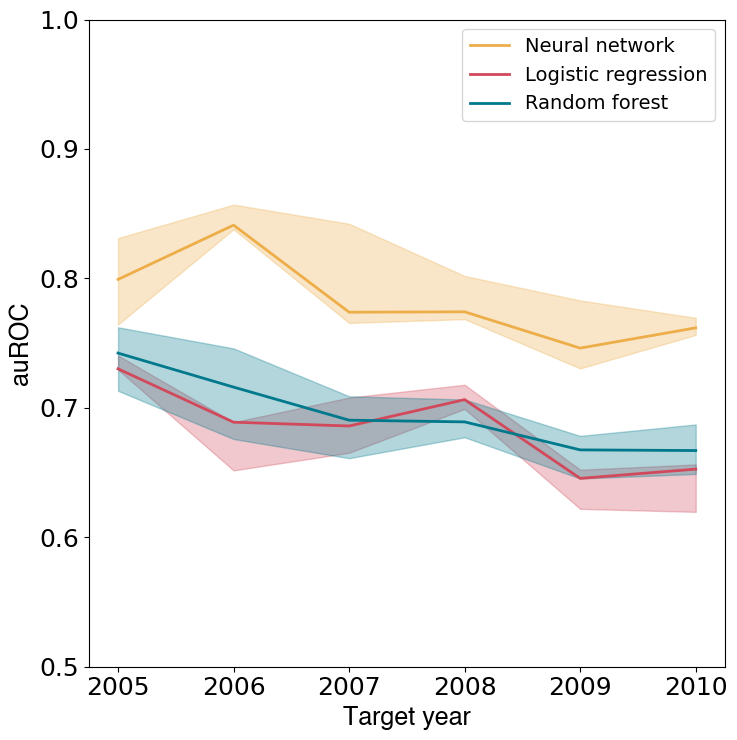

In [32]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")
axs.fill_between(years, lower_quartile_by_year_preloaded[2].values(), upper_quartile_by_year_preloaded[2].values(), color = "#edae49", alpha = 0.3)

axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.fill_between(years, lower_quartile_by_year_preloaded[0].values(), upper_quartile_by_year_preloaded[0].values(), color = "#d1495b", alpha = 0.3)

axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.fill_between(years, lower_quartile_by_year_preloaded[1].values(), upper_quartile_by_year_preloaded[1].values(), color = "#00798c", alpha = 0.3)

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()
axs.set_facecolor('w')
for spine in axs.spines.values():
    spine.set_edgecolor('k')
plt.savefig('Graphs_all_fatures_weights/auROC_by_year_all_models.png', dpi = 300)



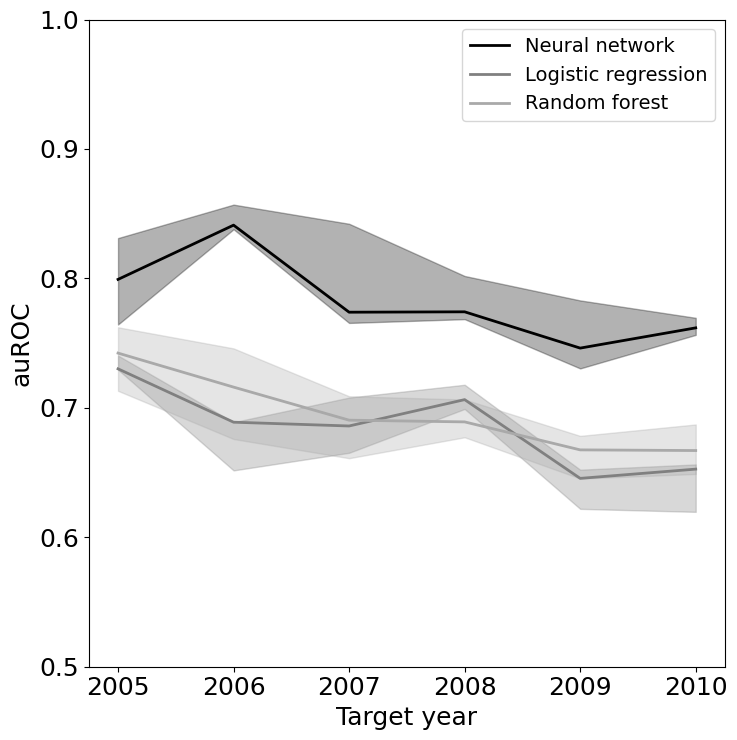

In [35]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex='all', sharey='all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
# axs.set_xticks([2005, 2007, 2010])

axs.plot(years, ROC_by_year[2].values(), linewidth=2, label="Neural network", color="black")
axs.fill_between(years, lower_quartile_by_year_preloaded[2].values(), upper_quartile_by_year_preloaded[2].values(), color="black", alpha=0.3)

axs.plot(years, ROC_by_year[0].values(), linewidth=2, label="Logistic regression", color="gray")
axs.fill_between(years, lower_quartile_by_year_preloaded[0].values(), upper_quartile_by_year_preloaded[0].values(), color="gray", alpha=0.3)

axs.plot(years, ROC_by_year[1].values(), linewidth=2, label="Random forest", color="darkgray")
axs.fill_between(years, lower_quartile_by_year_preloaded[1].values(), upper_quartile_by_year_preloaded[1].values(), color="darkgray", alpha=0.3)

axs.set_ylabel("auROC", fontsize=18)
axs.set_xlabel("Target year", fontsize=18)
axs.set_ylim([0.5, 1])
axs.legend(prop={'size': 14})
plt.tight_layout()
axs.set_facecolor('w')
for spine in axs.spines.values():
    spine.set_edgecolor('k')
plt.savefig('Graphs_all_fatures_weights/auROC_by_year_all_models_bw.png', dpi = 300)


In [39]:
def effective_unnecessary_threshold(
    threshold_seq, y_predict_proba, y_test, cipro_R_prevalence
):

    get_effective_threshold = []
    incorrectly_get_X_threshold = []  # no bootstrapping, no 95% CI
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:
        if model_type == 2:
            y_predict_test = np.where(y_predict_proba[:, 0] > threshold, 1, 0)
        else:
            y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test, fp_test, fn_test, tp_test = confusion_matrix(
            y_true=y_test, y_pred=y_predict_test
        ).ravel()

        sensitivity_test = tp_test / (tp_test + fn_test)
        specificity_test = tn_test / (tn_test + fp_test)

        sensitivity_threshold.append(sensitivity_test * 100)
        specificity_threshold.append(specificity_test * 100)
        get_effective_threshold.append(
            sensitivity_test * cipro_R_prevalence * 100
            + (100 - cipro_R_prevalence * 100)
        )  # q_p
        incorrectly_get_X_threshold.append(
            (100 - cipro_R_prevalence * 100) * (1 - specificity_test)
        )  # c_p"
    return (
        sensitivity_threshold,
        specificity_threshold,
        get_effective_threshold,
        incorrectly_get_X_threshold,
    )

In [93]:
def effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM, prevalence_no_HI_CAL_MSM,sensitivity, specificity, prop_in_CAL_HI_MSM
):

    get_effective_threshold =   sensitivity[len(sensitivity)- 1] * prevalence_no_HI_CAL_MSM * 100 + (100 - prevalence_no_HI_CAL_MSM * 100) + prevalence_HI_CAL_MSM
    incorrectly_get_X_threshold = (1 - prevalence_HI_CAL_MSM*1)* prop_in_CAL_HI_MSM*1* (specificity[len(specificity)- 1]) # opposite to previous specificity i think 
    return (

        get_effective_threshold,
        incorrectly_get_X_threshold,
    )
def bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, actual_sensitivity, actual_specificity):
      #1. Find apparent model performance
    lower_quartile_specificity_all = []
    upper_quartile_specificity_all = []
    lower_quartile_sensitivity_all = []
    upper_quartile_sensitivity_all = []
    for threshold in threshold_seq:
      bootstrapped_stats = []

      for j in range(iterations):
            if model_type == 2:
              model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) 
              model_fit = tf.keras.models.load_model(model_name)

            else:
                model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
                model_fit = pickle.load(open(model_name, 'rb'))

            X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            X_train_bootstrap = pd.read_csv(X_data_name)
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            #y_sample_predict = model_fit.predict(X_test)
            if model_type == 2: 
              y_bootstrap_predict_prob = model_fit.predict(X_test_for_bootstrap) #predicting it on the real data

              y_bootstrap_predict = np.where(y_bootstrap_predict_prob[:, 0] > threshold, 1, 0)            
            else:
              y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data

              y_bootstrap_predict = np.where(y_bootstrap_predict_prob[:, 1] > threshold, 1, 0)


            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y_test, y_pred=y_bootstrap_predict).ravel()

            sensitivity_test = (tp_test / (tp_test + fn_test))*100
            specificity_test = (tn_test / (tn_test + fp_test))*100

          ### (D) Calculate estimate fo variance  by getting (B) - (D) 
            difference_sensitivity = sensitivity_test - actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/
            difference_specificity = specificity_test - actual_specificity[np.where(threshold_seq ==threshold)[0][0]]  ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/


            bootstrapped_stats.append(
            {

                'Difference_specificity': difference_specificity, 
                'Difference_sensitivity': difference_sensitivity#,
            }
          )
      alpha = 0.05
      bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

      upper_quartile_senstivity, lower_quartile_sensitivity = actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_sensitivity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
      upper_quartile_specificity, lower_quartile_specificity = actual_specificity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_specificity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])



      lower_quartile_specificity_all.append(lower_quartile_specificity)
      upper_quartile_specificity_all.append(upper_quartile_specificity)
      lower_quartile_sensitivity_all.append(lower_quartile_sensitivity)
      upper_quartile_sensitivity_all.append(upper_quartile_senstivity)
 ## Step 4: Get optimization-corrected performance

    return lower_quartile_specificity_all, upper_quartile_specificity_all,lower_quartile_sensitivity_all,upper_quartile_sensitivity_all

def effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R, j):
          #    model = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters2['learning_rate'])
          if model_type == 2:
              model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) 
              model_fit = tf.keras.models.load_model(model_name)

          else:
                model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
                model_fit = pickle.load(open(model_name, 'rb'))
          X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
          X_train_bootstrap = pd.read_csv(X_data_name)
          X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
          #y_sample_predict = model_fit.predict(X_test)
          if model_type == 2:
              y_bootstrap_predict_prob = model_fit.predict(X_test_for_bootstrap) 
          else: 
            y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data
          sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_bootstrap_predict_prob, y_test, cipro_R)

          return sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold



# Info for plotting

In [58]:
indices = [0, 100, 200, 300, 400]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8','0.9', '1']
labels = ["A", "B", "C", "D", "E", "F" ]


# Added effective vs unnecessary 

In [105]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)

In [50]:
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

In [70]:
prop_in_CAL_HI_MSM = []
CAL_HI_MSM_by_year = []
cipro_prev_outside_CAL_HI_MSM = []
for year in test_years:
    year_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    MSM_CIPR =  (1 - year_data.loc[year_data['MSM'] == 1, 'Susceptible']).sum()
    MSW_CIPR =  (1 - year_data.loc[year_data['MSW'] == 1, 'Susceptible']).sum()
    MSMW_CIPR =  (1 - year_data.loc[year_data['MSMW'] == 1, 'Susceptible']).sum()
    Other_CIPR =  (1 - year_data.loc[year_data['Oth/Unk/Missing'] == 1, 'Susceptible']).sum()

    Not_MSM = MSW_CIPR + MSMW_CIPR + Other_CIPR
    HI_CAL =   (1 - (year_data[(year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]['Susceptible'])).sum()
    Not_CAL_HI =  (1 - (year_data[(~year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]['Susceptible'])).sum()
    cipro_prev_outside_CAL_HI_MSM.append((Not_MSM + Not_CAL_HI)/(len(year_data)))
    CAL_HI_MSM_by_year.append((MSM_CIPR + HI_CAL)/(len(year_data)))
    prop_in_CAL_HI_MSM.append(
    (len(year_data[(year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]) +
    len(year_data[(year_data['MSM'] == 1)])) /
    len(year_data)
)

In [53]:
prop_in_CAL_HI_MSM

[0.2822333387122801,
 0.26609724047306177,
 0.2526210683974039,
 0.22593045605451686,
 0.26546941678520625,
 0.2977676217261382]

In [52]:
CAL_HI_MSM_by_year

[0.06971115055672099,
 0.0937910643889619,
 0.08404060575802962,
 0.07216494845360824,
 0.05316500711237553,
 0.06908068201792934]

In [ ]:
###### Effect of threshold on year-by-year for logistic regression with bootstrapping
iterations = 100
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4'] #, '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0, 100, 200, 300, 400] #, 500, 600, 700, 800, 900, 1000]
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)


axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_lr = []
i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years:
    model_type = 0
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)


    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_lr.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    for j in range(iterations):
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)

        axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    
    # account for CAL_HI_MSM rule sensitivity, specificity
    if year in [2005, 2006, 2007]:
        effective_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold)[0]
        
        axs[i].plot(effective_with_CDC_rules,0, marker='x', ls='none', ms=14, color = "black")

    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_lr[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.savefig('Graphs_all_fatures_weights/Percent_effective_unnecessary_all_logistic_regression_2005_2010_weights_extra_features.png', dpi = 300)


KeyError: "['weight'] not in index"

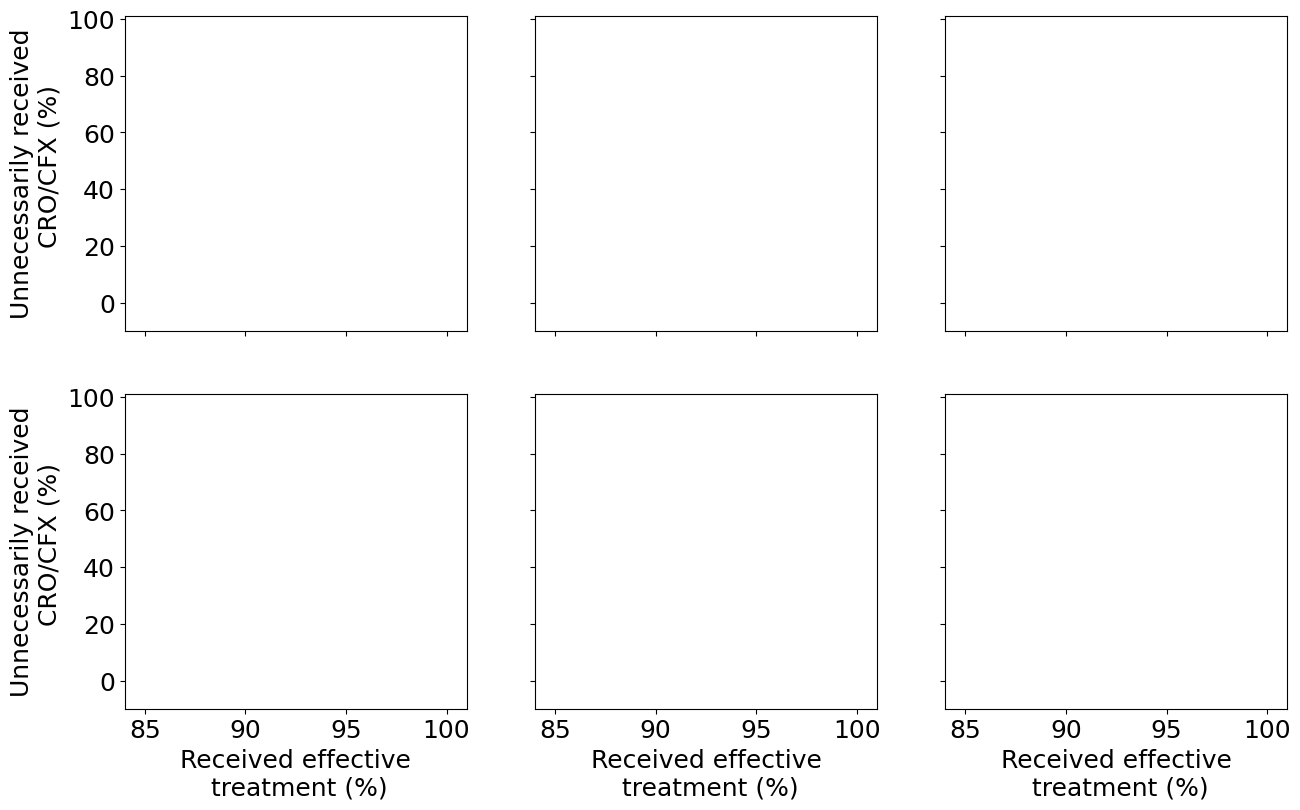

In [104]:
###### Effect of threshold on year-by-year for random forest model with bootstrap
from matplotlib.patches import Polygon
iterations = 100
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])


axs = axs.ravel()

cip_R_all_years = []
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_rf = []
i = 0
for year in years:
    model_type =1 
    years_train = np.array(range(year - 5, year))
    
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)


    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    #plot
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_rf.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    for j in range(iterations):
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)
        if(len(incorrectly_get_X_threshold_sample) == len(incorrectly_get_X_threshold)):
            axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    
    # account for CAL_HI_MSM rule sensitivity, specificity
    if year in [2005, 2006]:
        effective_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM= prop_in_CAL_HI_MSM[i])[0]
        unnecessary_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM = prop_in_CAL_HI_MSM[i])[1]

        axs[i].plot(effective_with_CDC_rules, unnecessary_with_CDC_rules, marker='x', ls='none', ms=14, color = "black", label = 'CDC')


    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45,  f'auROC: {ROC_by_year[model_type][year]:.3f}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 55, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle=":")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()

legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.savefig('Graphs_all_fatures_weights/Percent_effective_unnecessary_all_random_forest_2005_2010_bootstrap_weights_extra_features.png', dpi = 300)

In [310]:
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']
len(feature_names)

15

In [96]:
i = 1

In [ ]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

Oversample
194/194 [==============================] - 0s 198us/step
Oversample
191/191 [==============================] - 0s 217us/step
Oversample
188/188 [==============================] - 0s 212us/step
Oversample
179/179 [==============================] - 0s 208us/step
Oversample
176/176 [==============================] - 0s 203us/step
Oversample
178/178 [==============================] - 0s 200us/step


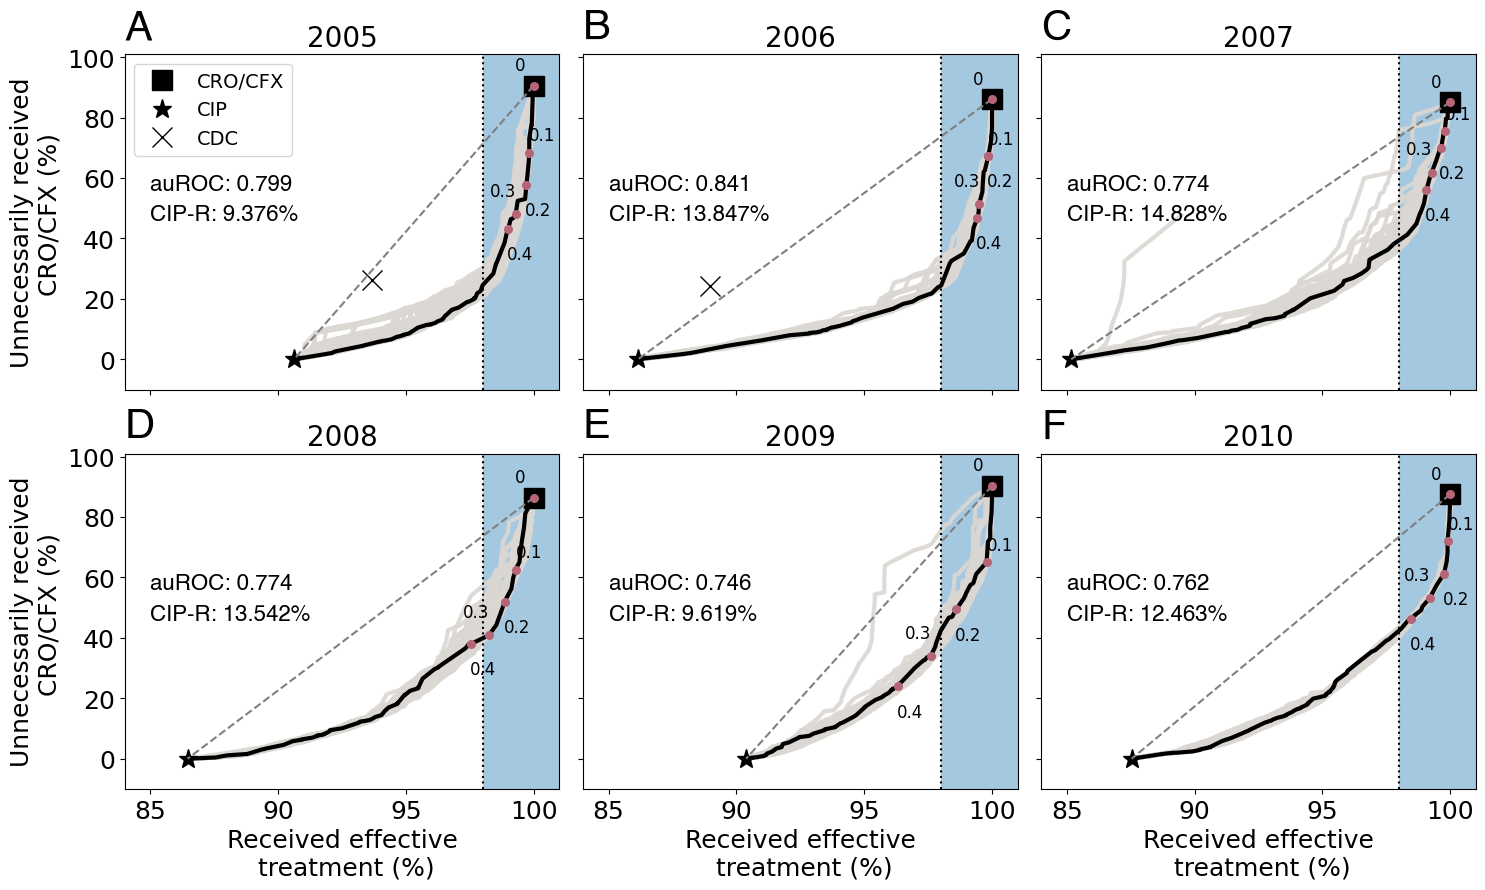

In [101]:
###### Effect of threshold on year-by-year for neural network with bootstrapping
iterations = 100
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4'] #, '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0, 100, 200, 300, 400] #, 500, 600, 700, 800, 900, 1000]
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)


axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_nn = []
i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years:
    model_type = 2
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    #X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
    #X_train_bootstrap = pd.read_csv(X_data_name)
    #X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]

    model_name = "CIP_nn_" + str(year) 
    model_fit = tf.keras.models.load_model(model_name)
    y_predict_proba = model_fit.predict(X_test) #in keras, predict gives probabilities
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_nn.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    for j in range(iterations):
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)
        if(len(incorrectly_get_X_threshold_sample) == len(incorrectly_get_X_threshold)):
            axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    
    # account for CAL_HI_MSM rule sensitivity, specificity
    if year in [2005, 2006]:
        effective_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM= prop_in_CAL_HI_MSM[i])[0]
        unnecessary_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM = prop_in_CAL_HI_MSM[i])[1]

        axs[i].plot(effective_with_CDC_rules, unnecessary_with_CDC_rules, marker='x', ls='none', ms=14, color = "black", label = 'CDC')

    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45,  f'auROC: {ROC_by_year[model_type][year]:.3f}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 55, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle=":")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.savefig('Graphs_all_fatures_weights/Percent_effective_unnecessary_all_neural_network_2005_2010_weights_extra_features.png', dpi = 300)


In [392]:
## how many unnecessarily get CRO or CFX at the 98% efficacy under the model predictions
unneccessary_treatment_98_efficacy_nn 

[28.610618040987575,
 25.952693823915904,
 38.642036944583126,
 39.45483138214223,
 37.51778093883357,
 42.99525399894534]

In [462]:
def reduction_in_unnecessary(mu_t, theta_prime):
    omega_prime = (1 - mu_t) / mu_t * (mu_t + theta_prime - 1)
    return omega_prime

In [419]:
cip_prev_by_year_all = [9.376, 13.847, 14.828, 13.542, 9.619, 12.463]
cipro_prev_outside_CAL_HI_MSM #outside cal, HI, MSM 
CAL_HI_MSM_by_year # inside CAL, HI, MSM 
theta_prime = 0.98

In [475]:
unnecessary_CAL_HI_MSM = []

for CIPR in CAL_HI_MSM_by_year:
    unnecessary_CAL_HI_MSM.append(reduction_in_unnecessary(CIPR, .98)*100)

unnecessary_not_CAL_HI_MSM = []

for CIPR in cipro_prev_outside_CAL_HI_MSM:
    unnecessary_not_CAL_HI_MSM.append(reduction_in_unnecessary(CIPR, .98)*100)

unnecessary_all = []

for CIPR in cip_prev_by_year_all:
    unnecessary_all.append(reduction_in_unnecessary(CIPR/100, .98)*100)



In [481]:
(prop_in_CAL_HI_MSM[0]*unnecessary_CAL_HI_MSM[0] + (1-prop_in_CAL_HI_MSM[0])*unnecessary_not_CAL_HI_MSM[0])

64.88398575570592

In [482]:
## for 2005 and 2006, need to weight 

red_2005 = (prop_in_CAL_HI_MSM[0]*unnecessary_CAL_HI_MSM[0] + (1-prop_in_CAL_HI_MSM[0])*unnecessary_not_CAL_HI_MSM[0]) - unneccessary_treatment_98_efficacy_nn[0]
red_2006 = (prop_in_CAL_HI_MSM[1]*unnecessary_CAL_HI_MSM[1] + (1-prop_in_CAL_HI_MSM[1])*unnecessary_not_CAL_HI_MSM[1]) - unneccessary_treatment_98_efficacy_nn[1]
red_2007 = unnecessary_all[2] - unneccessary_treatment_98_efficacy_nn[2]
red_2008 = unnecessary_all[3] - unneccessary_treatment_98_efficacy_nn[3]
red_2009 = unnecessary_all[4] - unneccessary_treatment_98_efficacy_nn[4]
red_2010 = unnecessary_all[5] - unneccessary_treatment_98_efficacy_nn[5]



In [484]:
red_2005

36.27336771471835

In [483]:
mean_red = np.mean([red_2005, red_2006, red_2007, red_2008, red_2009, red_2010], axis=0)
mean_red

36.10650779218462

# SI Graphs

Senistivity and specificity

Functions for SI

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


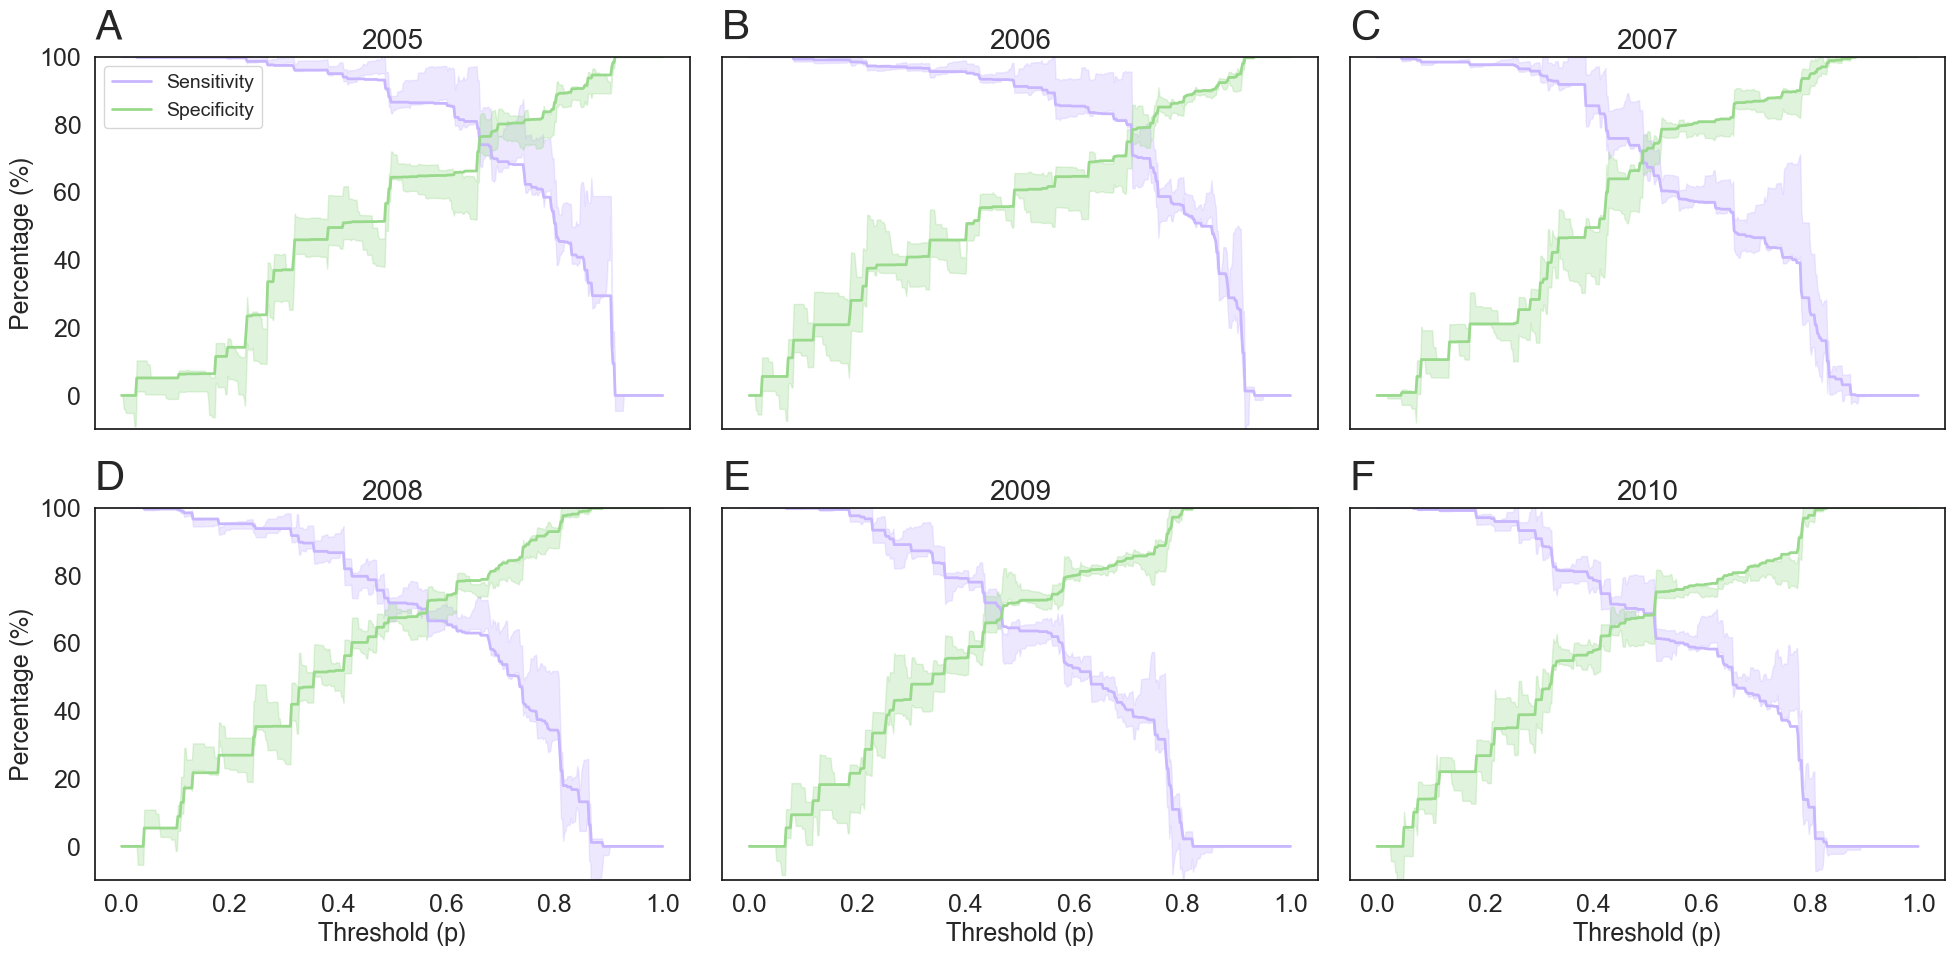

In [377]:
### RF Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    model_type = 1
    years_train = np.array(range(year - 5, year))
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)


    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()

plt.savefig("Graphs_all_fatures_weights/Sensitivity_specificity_all_workflow_paper_random_forest_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

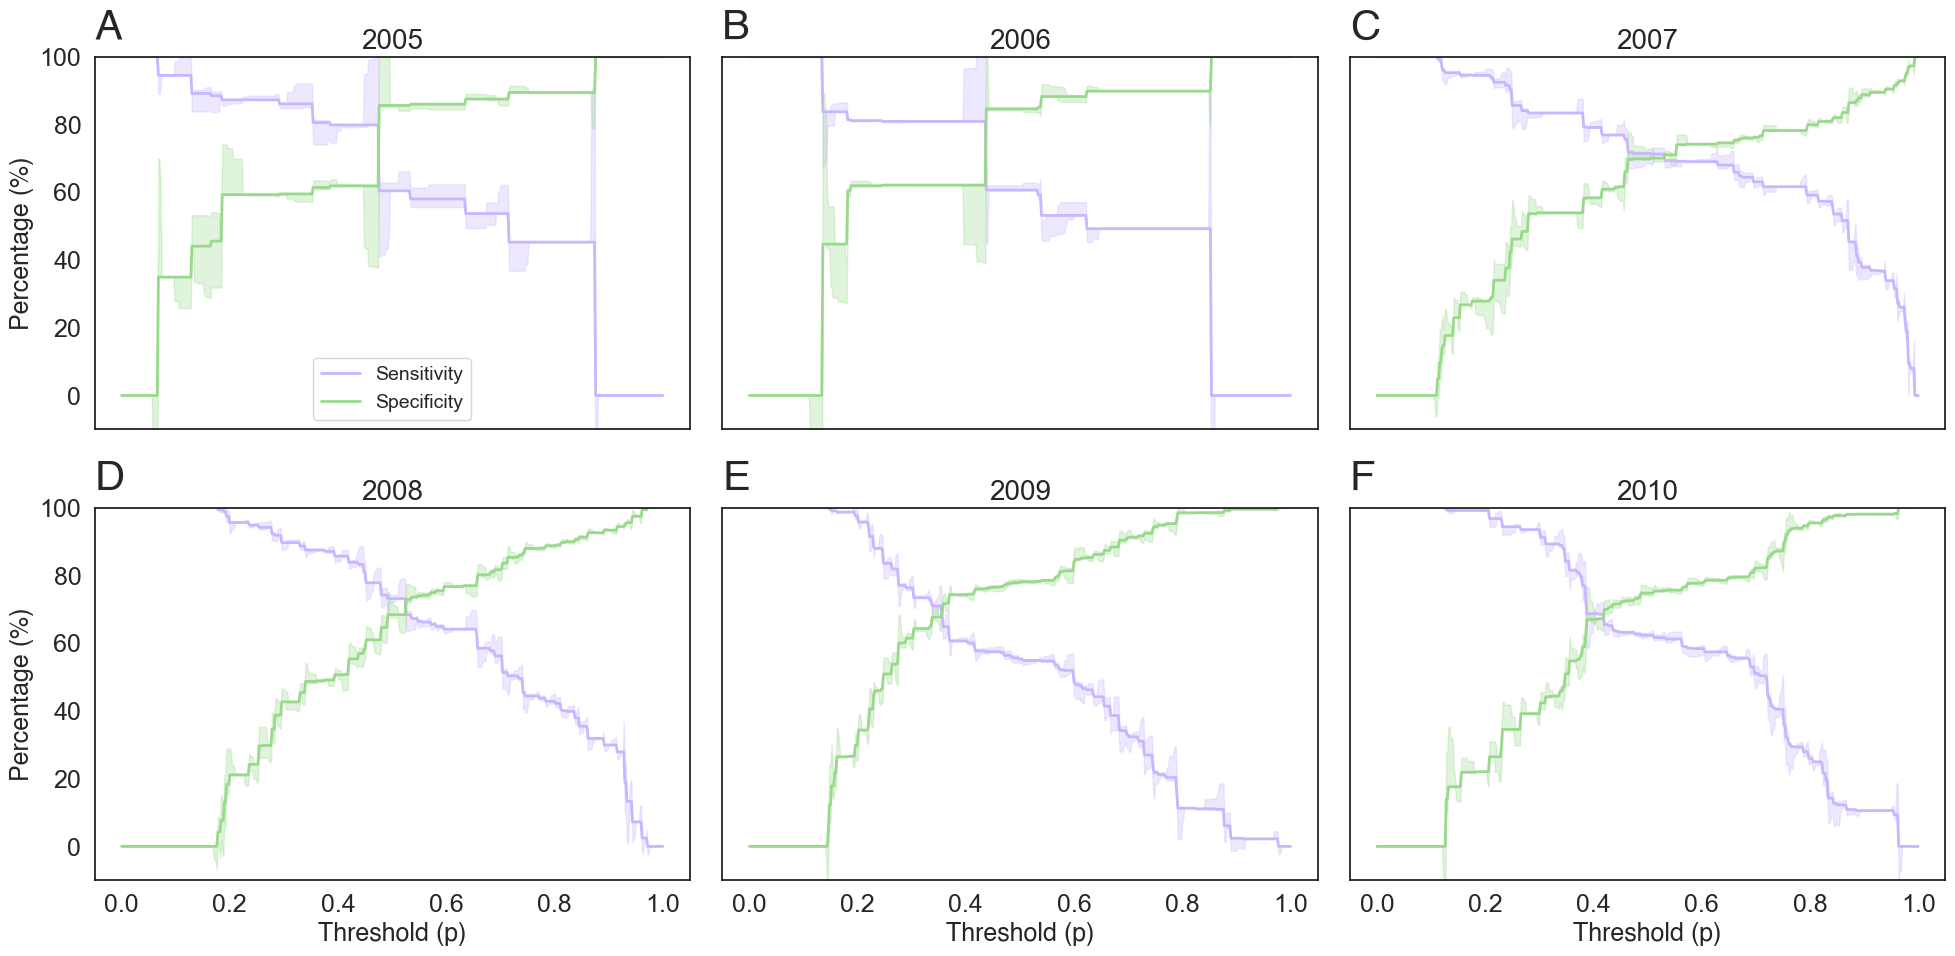

In [378]:
### LR Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)

i = 0
for year in years:
    model_type = 0
    years_train = np.array(range(year - 5, year))
    important_features = best_features_by_year[model_type][year]
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = 0)

    
    ## fit model
    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()

plt.savefig("Graphs_all_fatures_weights/Sensitivity_specificity_all_workflow_paper_logistic_regression_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

In [ ]:
### NN Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)
iterations = 10
i = 0
for year in years:
    model_type = 2
    years_train = np.array(range(year - 5, year))
    important_features = best_features_by_year[model_type][year]
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = 0)

    
    ## fit model
    model_name = "CIP_nn_" + str(year) 
    model_fit = tf.keras.models.load_model(model_name)
    y_predict_test = model_fit.predict(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_test, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()

plt.savefig("Graphs_all_fatures_weights/Sensitivity_specificity_all_workflow_paper_neural_network_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

# LOOCV 

In [344]:
def effective_unnecessary_threshold(
    threshold_seq, y_predict_proba, y_test, cipro_R_prevalence
):

    get_effective_threshold = []
    incorrectly_get_X_threshold = []  # no bootstrapping, no 95% CI
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:

        if model_type == 2:
            y_predict_test = np.where(y_predict_proba[:, 0] > threshold, 1, 0)
        else:
            y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(
            y_true=y_test, y_pred=y_predict_test
        ).ravel()

        sensitivity_test = tp_test / (tp_test + fn_test)
        specificity_test = tn_test / (tn_test + fp_test)

        sensitivity_threshold.append(sensitivity_test * 100)
        specificity_threshold.append(specificity_test * 100)
        get_effective_threshold.append(
            sensitivity_test * cipro_R_prevalence * 100
            + (100 - cipro_R_prevalence * 100)
        )  # q_p
        incorrectly_get_X_threshold.append(
            (100 - cipro_R_prevalence * 100) * (1 - specificity_test)
        )  # c_p"
    return (
        sensitivity_threshold,
        specificity_threshold,
        get_effective_threshold,
        incorrectly_get_X_threshold,
    )


In [489]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


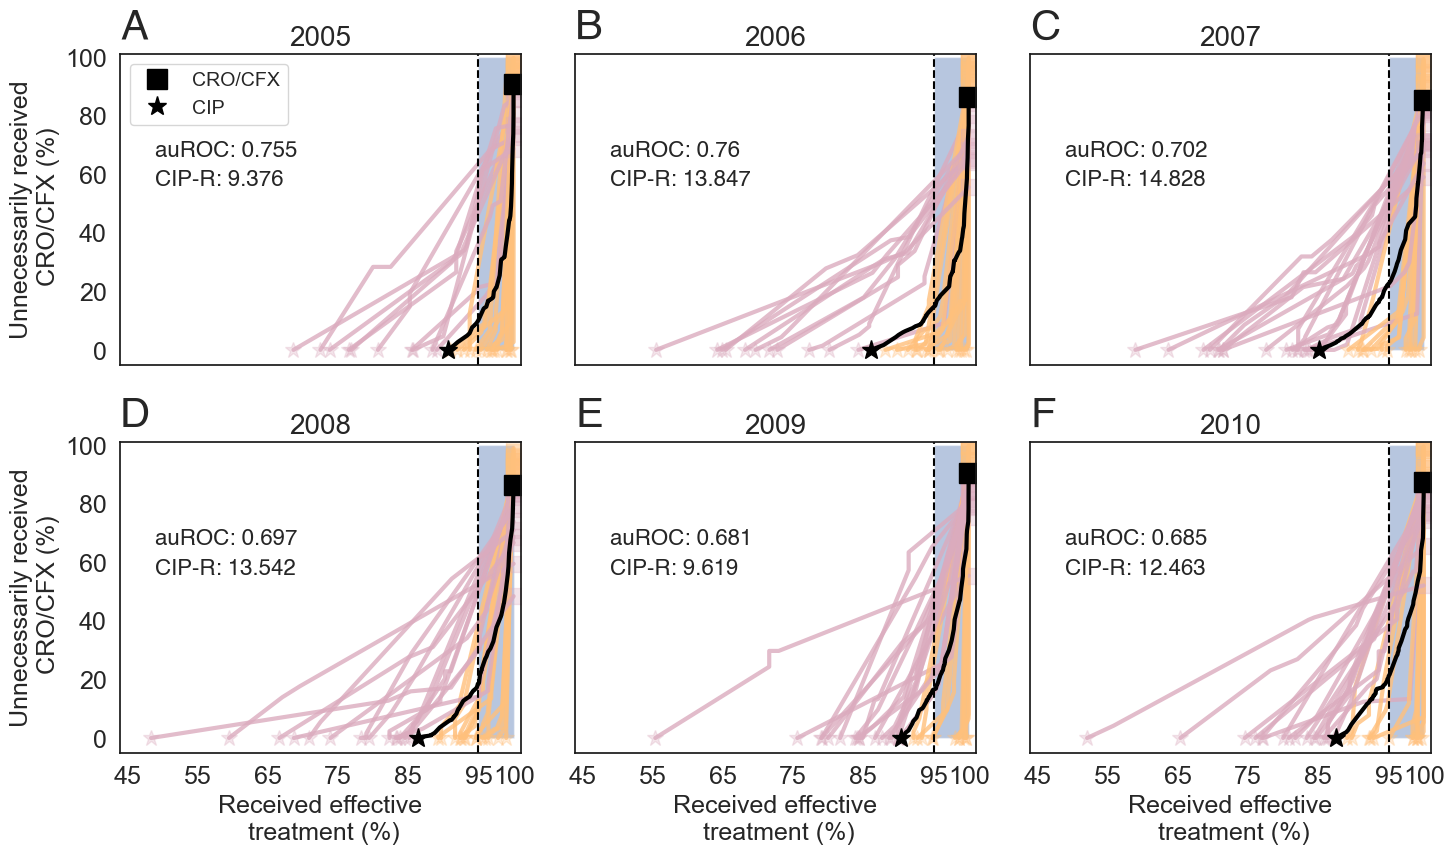

In [386]:
### Leave one out validation for random forest
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

##"full model"
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))
    model_type = 1
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    
    ## Load saved model
    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #get_effective_threshold_rf = get_effective_threshold
    #incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

          #train data - does not have clinic
        X_train = train_data[best_features_by_year[model_type][year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year[model_type][year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
              col = '#DBABBE'
              alpha_graph = 0.8
          else:
              col = '#ffc07c'
              alpha_graph = 0.8

          try:
          # test 
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:
              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year[model_type][year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1   #


axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  

for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
plt.savefig("Graphs_all_fatures_weights//LOOCV_effective_unnecessary_all_workflow_paper_random_forest_2005_2010_coloured.png", dpi = 300)

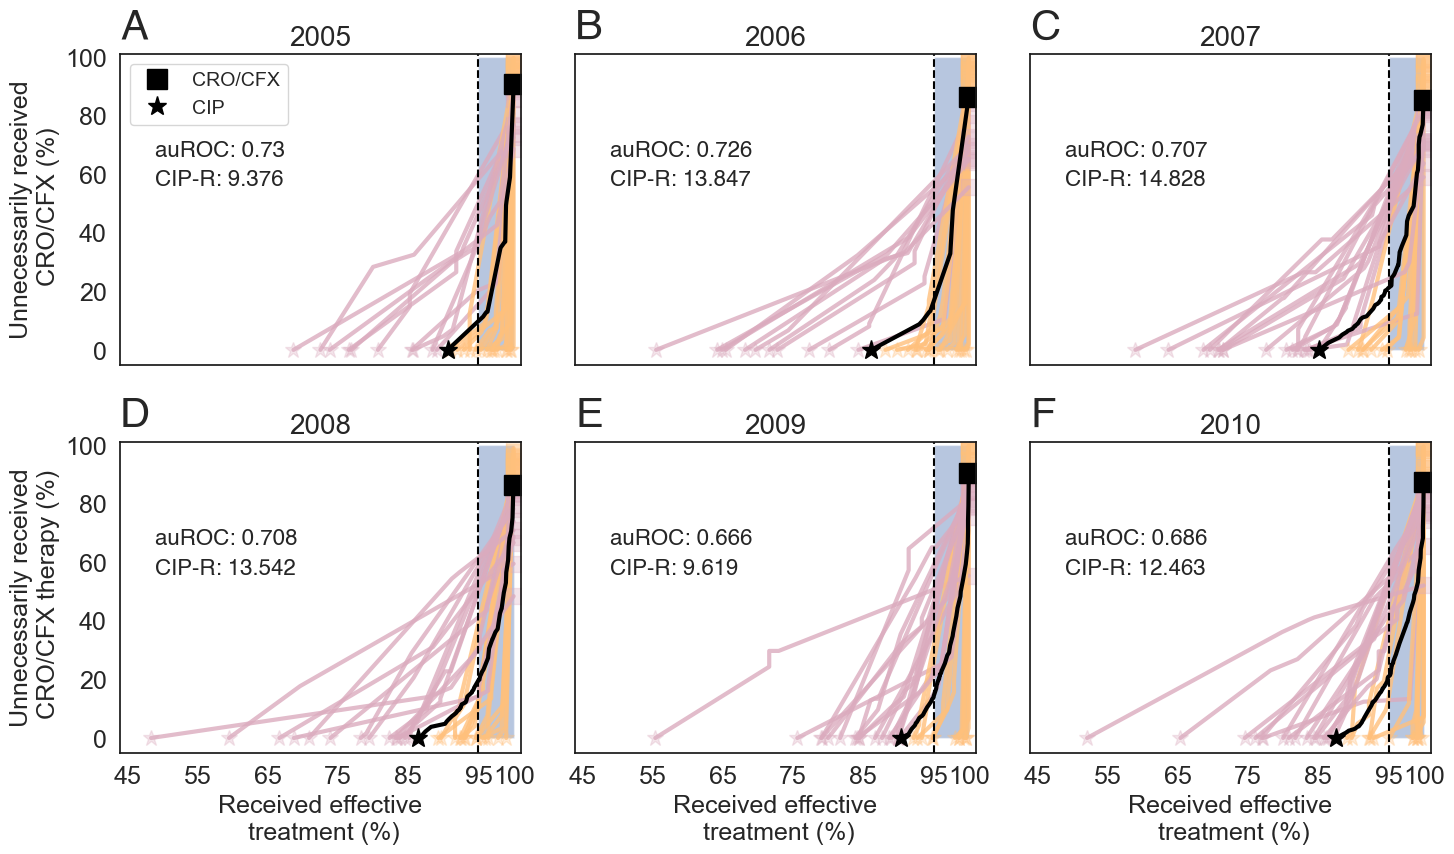

In [490]:
### Leave one out validation for logistic regression 
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)


axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
threshold_seq = np.linspace(0,1,1001)

years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years: 
    years_train = np.array(range(year - 5, year))

    model_type = 0
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    
    ## Load saved model
    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #get_effective_threshold_rf = get_effective_threshold
    #incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]

          #train data - does not have clinic
        X_train = train_data[best_features_by_year[model_type][year]]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year[model_type][year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
            
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              if cipro_R_prev < cipro_R:
                col = '#DBABBE'
                alpha_graph = 0.8
              else:
                 col = '#ffc07c'
                 alpha_graph = 0.8
              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:

              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year[model_type][year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1   #
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
plt.savefig("Graphs_all_fatures_weights//LOOCV_effective_unnecessary_all_workflow_paper_logistic_regression_2005_2010_coloured.png", dpi = 300)

8/8 [==============================] - 0s 367us/step


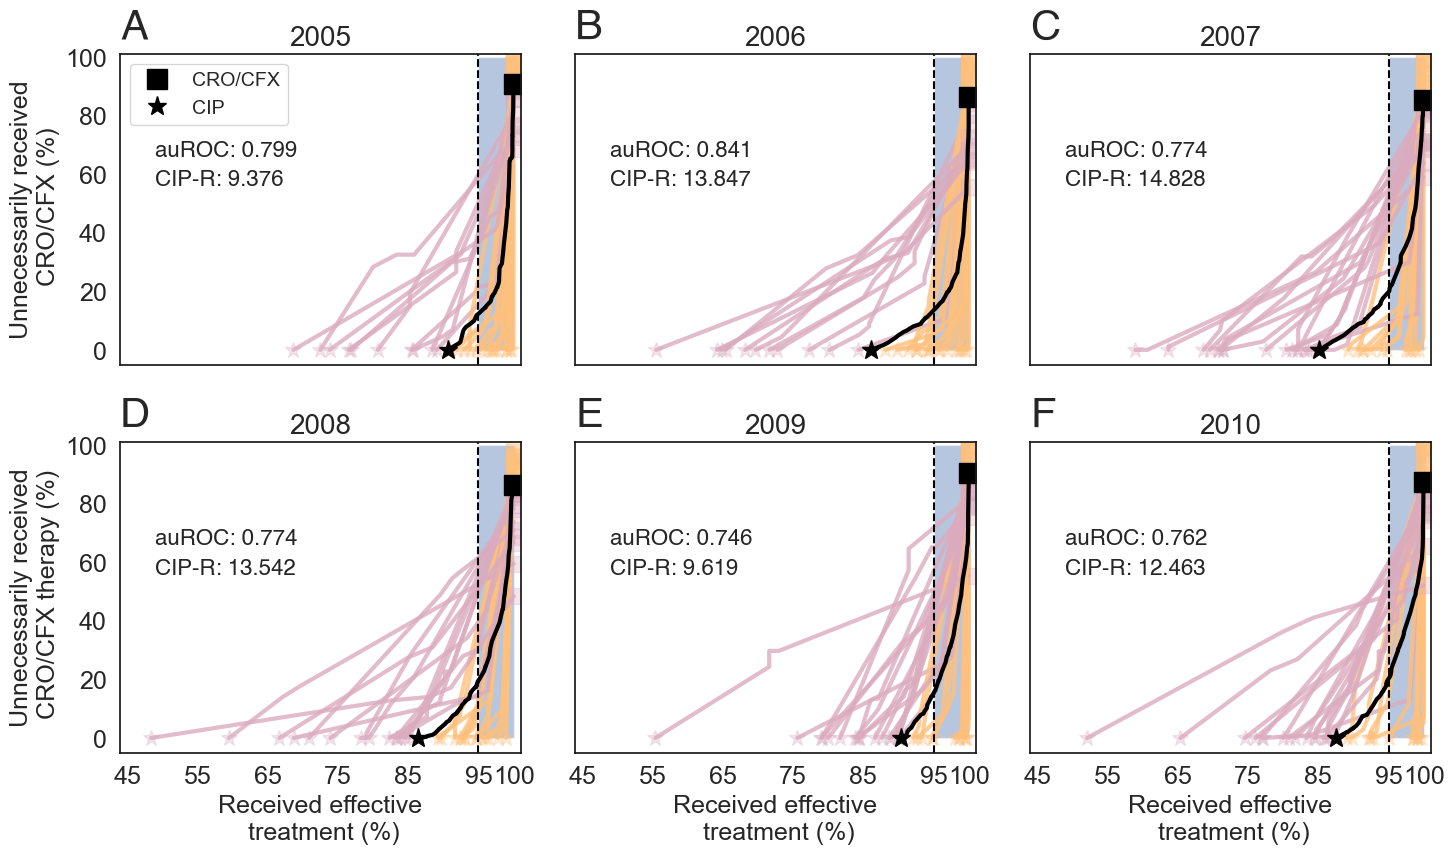

In [375]:
### Leave one out validation for neural network 
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)


axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
threshold_seq = np.linspace(0,1,1001)

years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years: 
    years_train = np.array(range(year - 5, year))

    model_type = 2
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    
    ## Load saved model
    model_name = "CIP_nn_" + str(year)
    model_fit = tf.keras.models.load_model(model_name)
    y_predict_test = model_fit.predict(X_test)

 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_test, y_test, cipro_R_prev)
    #get_effective_threshold_rf = get_effective_threshold
    #incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]

          #train data - does not have clinic
        X_train = train_data[best_features_by_year[model_type][year]]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year[model_type][year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
            
              y_predict_test = model_fit.predict(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_test, y_test, cipro_R)
              if cipro_R_prev < cipro_R:
                col = '#DBABBE'
                alpha_graph = 0.8
              else:
                 col = '#ffc07c'
                 alpha_graph = 0.8
              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:

              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {ROC_by_year[model_type][year]:.3f}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1   #
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
plt.savefig("Graphs_all_fatures_weights//LOOCV_effective_unnecessary_all_workflow_paper_neural_network_2005_2010_coloured.png", dpi = 300)

In [233]:
print("RF:",ROC_by_year)
print("RF:",best_hyperparameters_by_year)
print("RF:",best_features_by_year)

RF: [{2005: 0.7301280825377211, 2006: 0.7261538130988446, 2007: 0.7066233521880259, 2008: 0.7078638485409549, 2009: 0.6664640534593402, 2010: 0.6856022113843243}, {2005: 0.7549897391764862, 2006: 0.7595409738925509, 2007: 0.7015889650707939, 2008: 0.6966628419433072, 2009: 0.680609279672774, 2010: 0.6846061254892631}, {2005: 0.79921305, 2006: 0.84113616, 2007: 0.7738805, 2008: 0.7741755, 2009: 0.7461454, 2010: 0.7617777}]
RF: [{2005: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2009: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007:

In [365]:
len(y_predict_test[:,0])
len(y_test)

6197

Oversample
194/194 [==============================] - 0s 237us/step
Oversample
191/191 [==============================] - 0s 223us/step
Oversample
188/188 [==============================] - 0s 300us/step
Oversample
179/179 [==============================] - 0s 605us/step
Oversample
176/176 [==============================] - 0s 331us/step
Oversample
178/178 [==============================] - 0s 203us/step
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


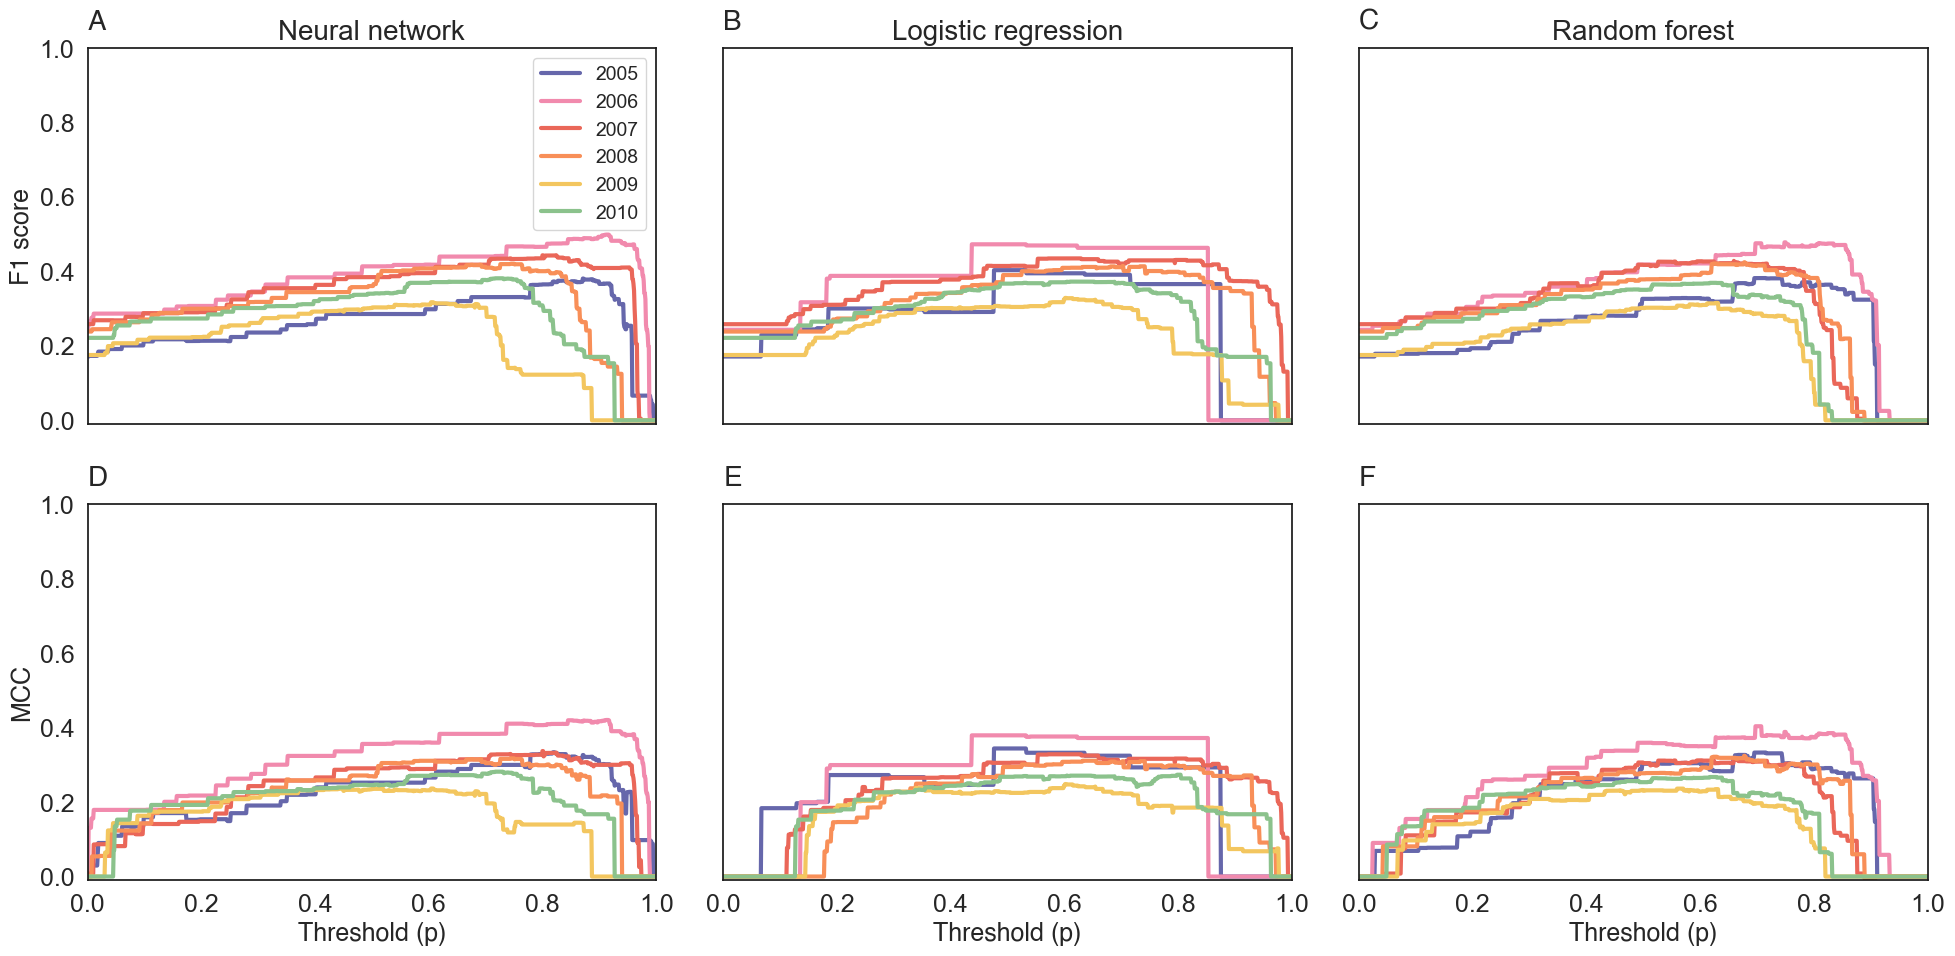

In [507]:
###### Performance criteria by year and model 
def f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test, model_type):

    f1_score_seq = []
    mcc_score_seq = []
    for threshold in threshold_seq:
        if model_type == 2:
             y_predict = np.where(y_predict_proba[:, 0] > threshold, 1, 0)
        else:
            y_predict = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        f1_score_seq.append(f1_score(y_test, y_predict))
        mcc_score_seq.append(matthews_corrcoef(y_test, y_predict))
    return(f1_score_seq, mcc_score_seq)

## set up for figure 
threshold_seq = np.linspace(0,1,1001)

### calculate scores 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
colors = ["#6667ab", "#f18aad", "#ea6759", "#f88f58", "#f3c65f", "#8bc28c"]
labels = ["A", "B", "C", "D", "E", "F" ]

test_years = [2005, 2006, 2007, 2008, 2009, 2010]

axs[0,0].set_ylabel('F1 score', fontsize = 18, **hfont)
axs[1,0].set_ylabel('MCC', fontsize = 18, **hfont)
axs[1,0].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,1].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,2].set_xlabel("Threshold (p)", fontsize = 18, **hfont)

axs[0,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)

axs[0,0].set_ylim([0-.010,1])
axs[0,0].set_xlim([0, 1])

axs = axs.ravel()

for i in range(3):
    x = 0

    if i == 0:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_type = 2
            CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
            CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
            # first do for all clinics 
            counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
            counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

            merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

            # Calculate the sum of all counts in the counts dataframe
            total_counts = counts['Count'].sum()

            # Calculate the 'weight' column as Count_counts / total_counts
            merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
            # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

            # Merge the 'weight' column back to the original DataFrame
            CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
            # first do for all clinics 
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)

            model_name = "CIP_nn_" + str(year)
            model_fit = tf.keras.models.load_model(model_name)
            ## fit model w/hyperparameters 
            y_predict_proba = model_fit.predict(X_test)

            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test, model_type )
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3)
            CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Neural network",fontsize=20)
        axs[i].legend()


    if i == 1:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_type = 0
            CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
            CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
            # first do for all clinics 
            counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
            counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

            merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

            # Calculate the sum of all counts in the counts dataframe
            total_counts = counts['Count'].sum()

            # Calculate the 'weight' column as Count_counts / total_counts
            merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
            # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

            # Merge the 'weight' column back to the original DataFrame
            CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
            # first do for all clinics 
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)


            # first do for all clinics 

            model_name = "CIP_lr_" + str(year) + ".sav" 
            model_fit_train = pickle.load(open(model_name, 'rb'))
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test, model_type)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)
            CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

            x += 1
   
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Logistic regression",fontsize=20)

    
    if i == 2:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_type = 1
            CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
            CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
            # first do for all clinics 
            counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
            counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

            merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

            # Calculate the sum of all counts in the counts dataframe
            total_counts = counts['Count'].sum()

            # Calculate the 'weight' column as Count_counts / total_counts
            merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
            # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

            # Merge the 'weight' column back to the original DataFrame
            CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
            # first do for all clinics 
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)

            model_name = "CIP_rf_" + str(year) + ".sav" 
            model_fit_train = pickle.load(open(model_name, 'rb'))
            y_predict_proba = model_fit_train.predict_proba(X_test)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test, model_type)

            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)
            CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Random forest",fontsize=20)
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  


for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
plt.savefig('Graphs_all_fatures_weights/F1_MCC_score_all_years_all_models.png', dpi = 300)


In [502]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)

In [505]:
            CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
